In order to complete my first capstone project for the Thinkful data science course, I reached out to my family email group for any ideas for a research topic. I recieved several suggestions but decided to pursue a sports-related topic because I know there is a lot of easy-to-access sports data available.


My cousin is curious about a correlation between pitchers' activity in one season and their being placed on the disabled list the next season. In order to make this question approachable with my very limited experience working with messy data, I've decided to look specifically at the 2015 and 2016 seasons.


The number of innings pitched per season is a starting point but probably insufficient. Starting pitchers will appear in far more innings than the rest of the pitching staff, for example. I'll try to come up with a notion of a "normal" season for a given pitcher based on their career history to see if there's a correlation between a relatively busy season for a pitcher and joining the disabled list.

    
    
Questions:

(1) Of the MLB pitchers who appeared in both the 2015 and 2016 seasons, how many appeared on the disabled list (DL) in 2016 for the first time in that period? (Appear on the DL in 2016 and not in 2015).

(2) Is there a correlation between those pitchers who joined the DL in 2016 and the number of outs pitched (or innings pitched times three) they pitched in the 2015 season?


(3) Is there a correlation between those pitchers and their activity in the 2015 season as compared to their average activity per season?

In [46]:
import numpy as np
import pandas as pd
from datawrangler import players_outs, format_names, reconcile_names, consol, fill_gaps, tally_outs, season_load
from analyzer import report, set_plot
import matplotlib.pyplot as plt
%matplotlib inline

I found a comprehensive list of pitcher information as a part of the exhaustive Lahman's Baseball Database set (http://www.seanlahman.com/baseball-archive/statistics/). It includes player stats dating back to 1871, which is really cool! However, the scope of this project is pitchers with MLB appearances in both 2015 and 2016. Pitchers can have really long careers - Nolan Ryan holds the record, appearing in a total of 27 MLB seasons spanning 28 years. 


To make sure we have all the career data for any pitchers who may compete with Ryan's record, I'll use the Lahman set back to the 1989 season. For the scope of my questions, I'm just going to take the IPouts (innings * 3) stats for each player for each team and season:

In [47]:
pitch = pd.read_csv('Pitching.csv')
mp = pitch[pitch["yearID"] >= 1989]
pitchers = pd.DataFrame(columns=['playerID', 'year', 'Outs Pitched'])
pitchers['playerID'], pitchers['year'], pitchers['Outs Pitched'] = mp['playerID'], mp['yearID'], mp['IPouts']

I'll generate a 'career profile' for each pitcher on this list using the players_outs() function. It returns a dictionary where the key is the player's name and the value is a pandas dataframe with their career information:

In [48]:
players = players_outs(pitchers)

We want to remove all players who did not appear in both the 2015 and 2016 seasons:

In [49]:
players_to_exclude = []
for player in players:
    ya = list(players[player]['Year']) #ya short for "years active"
    if not ((2015 in ya) and (2016 in ya)):
        players_to_exclude.append(player)
        
for player in players_to_exclude:
    del players[player]
    
print('\t{} pitchers appeared in both the 2015 and 2016 seasons.'.format(len(players)))

	526 pitchers appeared in both the 2015 and 2016 seasons.


I collected the disabled list information for the 2015 and 2016 seasons from baseballheatmaps.com (http://www.baseballheatmaps.com/disabled-list-data/). For now, I'm going to include all pitchers who appeared on the disabled list regardless of the specific reason for disability. I may come back and narrow my search to Tommy John surgeries (associated with overuse in pitchers), but I'm looking for a more general trend right now.

In [50]:
inj2015 = pd.read_csv('2015_disabled_list.csv')
inj2015_1 = inj2015[inj2015['Position'] == 'RHP']
inj2015_2 = inj2015[inj2015['Position'] == 'LHP']
inj2015 = pd.concat([inj2015_1, inj2015_2]).copy()
inj2015_names = list(set(inj2015['Name'])) #set() call removes duplicates, as some players appear more than once.

inj2016 = pd.read_csv('2016_disabled_list.csv')
inj2016_1 = inj2016[inj2016['Position'] == 'RHP']
inj2016_2 = inj2016[inj2016['Position'] == 'LHP']
inj2016 = pd.concat([inj2016_1, inj2016_2]).copy()
inj2016_names = list(inj2016['Name'])
inj2016_names = list(set(inj2016_names)) #set() call removes duplicates, as some players appear more than once.

The names on the disabled list appear in a different format than those on the Lahman's list. I'll reformat them:

In [51]:
inj2015_names = format_names(inj2015_names)
inj2016_names = format_names(inj2016_names)

I go through both lists to make a list of those players who appear on the 2016 DL and not 2015:

In [52]:
newly_injured = []
for name in inj2016_names:
    if name not in inj2015_names:
        newly_injured.append(name)

The Lahman data set has so many players that it runs into duplicate player names (the first five letters of the last name and first two letters of the first name). It uses a number, starting at 01 which denotes the first instance of that name code, and counting up. To reconcile our reformatted injured players list with the Lahman player names, I built the reconcile_names() function. Any names it does not find in our data set will be returned as a list from the function. These are players who did not appear in both the 2015 and 2016 seasons but did appear on the 2016 DL; in the majority of cases, they debuted and appeared on the DL in 2016.


Important exception: Rubby de la Rosa is coded "delarru01" in the Lahman set and so was improperly formatted. I'll fix that before running the reconcile_names() function.

In [53]:
newly_injured.remove('rosaru01')
newly_injured.append('delarru01')
newly_injured, missing_players = reconcile_names(newly_injured, players)
for player in missing_players:
    newly_injured.remove(player)

Because of the way the Lahman's set is put together, some players have multiple entries for the same year. This occurs when players pitch for multiple teams in the same season. I made the consol() function to take care of that by finding duplicate years in a player's career profile, adding the outs pitched from each row, adding these together, and creating a single consolidated row with the total outs pitched that year.

In [54]:
for player in players:
    players[player] = consol(players[player])

If a pitcher misses a year, he has no entry in the Lahman set. I built the fill_gaps() function to fill in gaps in the data set. We'll include these years and '0' for the number of outs pitched for the sake of consistency.

In [55]:
for player in players:
    players[player] = fill_gaps(players[player])

The tally_outs function will add two columns to each player's career profile. 'Outs TD Start' is the total number of outs pitched at the start of the season, and 'Outs TD Finish' is the total number of outs pitched at the end of that season.

In [56]:
for player in players:
    players[player] = tally_outs(players[player])

The season_load() function calculates a value called 'Season Load' for a given player. This is a simple metric I came up with to roughly calculate a pitcher's activity compared with the 'normal' activity for a pitcher, that is, the average number of outs pitched in a season. An 'average' season load will have a value of 1, a busy season will have be more than 1, and a less active season will be less than one (but always positive). If a player does not appear in a season, the load will be zero.

In [57]:
for player in players:
    players[player] = season_load(players[player])

With the information we've aggregated so far, we can answer the first question:

In [58]:
len(newly_injured)/len(players)

0.2661596958174905

Of the MLB pitchers who appeared in both the 2015 and 2016 seasons, 26.6% appeared on the disabled list (DL) in 2016 for the first time in that period (2015-2016).

Let's look at the numbers.

I'll first divide the pitchers who appeared in 2015 and 2016 into ten groups, ranked by the total number of outs pitched. Each group contains an equal number of pitchers.

Then we'll see how many of the players who ended up on the disabled list belong to which group. I'll give you a nice graphic to better understand the way I've broken down the information. The line plotted on the graph represents all the pitchers who appeared in 2015 and 2016, and the red x's represent those who ended up on the DL in 2016.

First we'll rank the players by the total number of outs pitched in 2015:

Group 1, 10.0% of all players, represents 7.142857142857142% of the group.
Group 2, 10.0% of all players, represents 5.0% of the group.
Group 3, 10.0% of all players, represents 7.857142857142857% of the group.
Group 4, 10.0% of all players, represents 7.857142857142857% of the group.
Group 5, 10.0% of all players, represents 9.285714285714286% of the group.
Group 6, 10.0% of all players, represents 13.571428571428571% of the group.
Group 7, 10.0% of all players, represents 14.285714285714285% of the group.
Group 8, 10.0% of all players, represents 5.714285714285714% of the group.
Group 9, 10.0% of all players, represents 9.285714285714286% of the group.
Group 10, 10.0% of all players, represents 17.857142857142858% of the group.


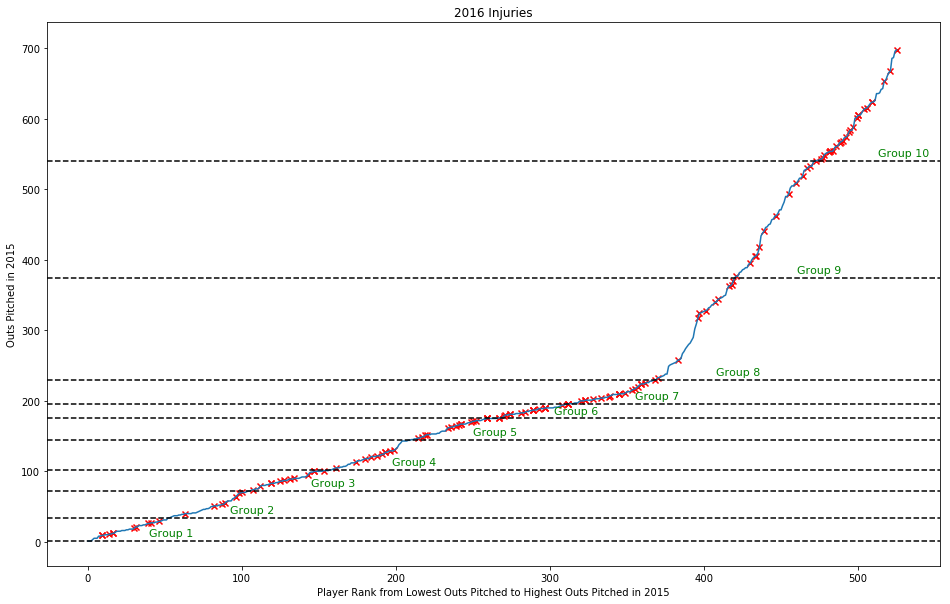

In [59]:
report(players, newly_injured, 'Outs Pitched', 10, 2015)
set_plot(players, newly_injured, 'Outs Pitched', 10, 2015)

We can see that the distribution is fairly even across all of the groups. It's worth noting that nearly 18% of the pitchers that ended up on the DL were within the top 10% most active group of pitchers, labeled group 10 on the plot. Group 10 saw the most players end up on the DL in 2016. 

Now let's see how the same information looks if we use the normalized 'season load' metric:

Group 1, 10.0% of all players, represents 6.428571428571428% of the group.
Group 2, 10.0% of all players, represents 7.142857142857142% of the group.
Group 3, 10.0% of all players, represents 5.0% of the group.
Group 4, 10.0% of all players, represents 9.285714285714286% of the group.
Group 5, 10.0% of all players, represents 9.285714285714286% of the group.
Group 6, 10.0% of all players, represents 7.857142857142857% of the group.
Group 7, 10.0% of all players, represents 13.571428571428571% of the group.
Group 8, 10.0% of all players, represents 12.142857142857142% of the group.
Group 9, 10.0% of all players, represents 10.0% of the group.
Group 10, 10.0% of all players, represents 14.285714285714285% of the group.


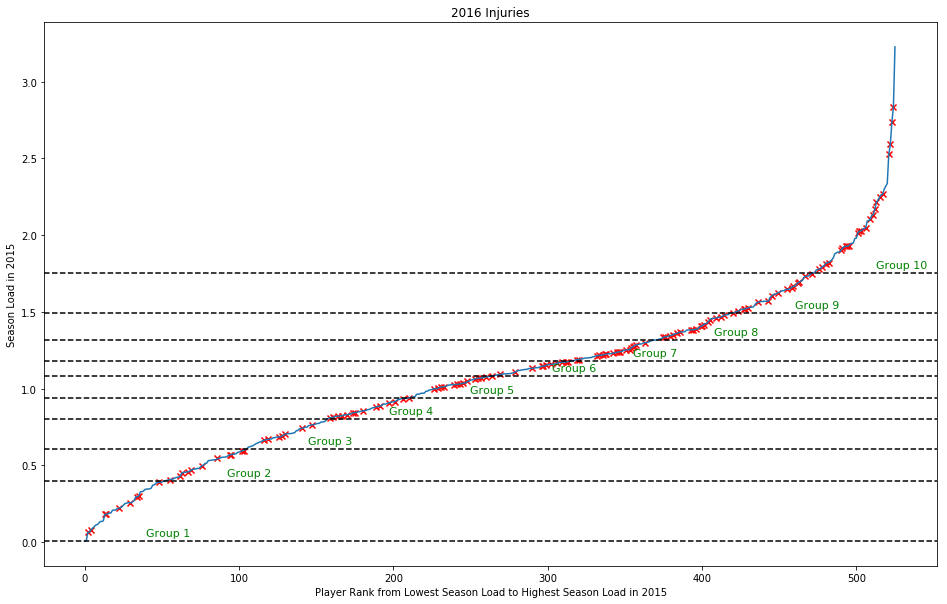

In [60]:
report(players, newly_injured, 'Season Load', 10, 2015)
set_plot(players, newly_injured, 'Season Load', 10, 2015)

Group 10, the 10% most active by this metric, still has the highest concentration of pitchers who end up on the disabled list in 2016. However, this correlation does not seem as strong, with less than 15% of the pitchers in this group on the 2016 DL.

It may not be surprising that a slightly higher number of the most active pitchers in 2015 appeared on the disabled list in 2016, but it's worth noting that the distribution is fairly even across all activity groups.

Just for curiosity's sake, let's take a look at the same information for 2016. Keep in mind there's a built-in tendency for injured players to pitch less innings in 2016 - their placement on the disabled list keeps them from playing.

Group 1, 10.0% of all players, represents 6.428571428571428% of the group.
Group 2, 10.0% of all players, represents 9.285714285714286% of the group.
Group 3, 10.0% of all players, represents 8.571428571428571% of the group.
Group 4, 10.0% of all players, represents 10.0% of the group.
Group 5, 10.0% of all players, represents 15.0% of the group.
Group 6, 10.0% of all players, represents 10.714285714285714% of the group.
Group 7, 10.0% of all players, represents 5.714285714285714% of the group.
Group 8, 10.0% of all players, represents 15.0% of the group.
Group 9, 10.0% of all players, represents 13.571428571428571% of the group.
Group 10, 10.0% of all players, represents 2.857142857142857% of the group.


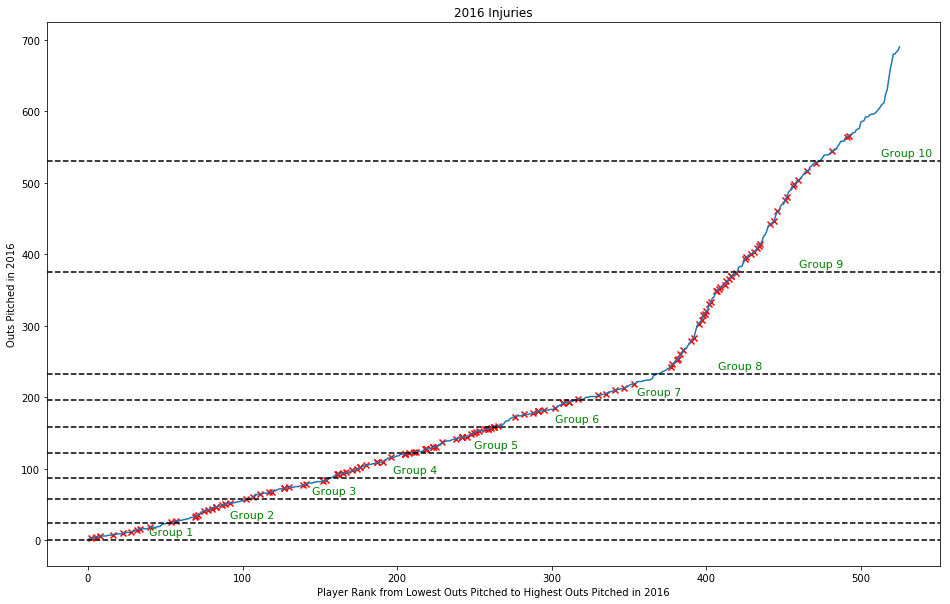

In [61]:
report(players, newly_injured, 'Outs Pitched', 10, 2016)
set_plot(players, newly_injured, 'Outs Pitched', 10, 2016)

Group 1, 10.0% of all players, represents 7.857142857142857% of the group.
Group 2, 10.0% of all players, represents 11.428571428571429% of the group.
Group 3, 10.0% of all players, represents 15.714285714285714% of the group.
Group 4, 10.0% of all players, represents 11.428571428571429% of the group.
Group 5, 10.0% of all players, represents 11.428571428571429% of the group.
Group 6, 10.0% of all players, represents 9.285714285714286% of the group.
Group 7, 10.0% of all players, represents 8.571428571428571% of the group.
Group 8, 10.0% of all players, represents 9.285714285714286% of the group.
Group 9, 10.0% of all players, represents 8.571428571428571% of the group.
Group 10, 10.0% of all players, represents 3.571428571428571% of the group.


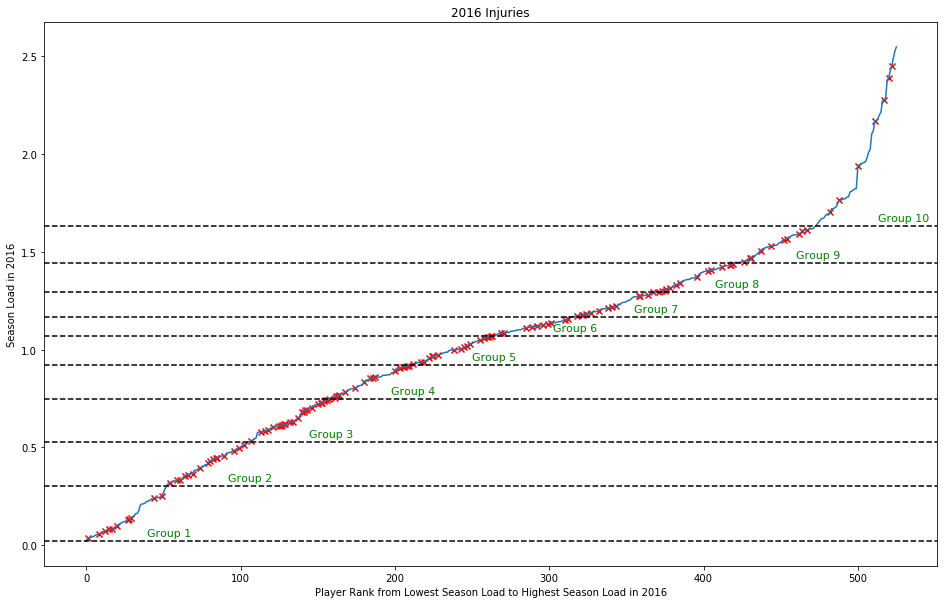

In [62]:
report(players, newly_injured, 'Season Load', 10, 2016)
set_plot(players, newly_injured, 'Season Load', 10, 2016)

As expected, if we look at pitcher activity in 2016, the correlation with injuries tends to be closer to the lower groups.

This analysis includes pitchers who were enrolled in the 2016 disabled list for any reason. As my brother pointed out, players may end up on the DL for any reason, including injuries they sustain during recreational activities unrelated to baseball. Let's narrow our search down to only players who underwent Tommy John surgery in 2016. This infamous procedure is a trademark of overuse in pitchers.

This time we'll include players who appeared on the 2015 DL as well, and just look for a correlation between 2015 activity and Tommy John surgeries in 2016.

In [63]:
tj2016_1 = inj2016_1[inj2016_1['Injury Type'] == 'Tommy John surgery']
tj2016_2 = inj2016_2[inj2016_2['Injury Type'] == 'Tommy John surgery']

In [64]:
tj_names = list(tj2016_1['Name']) + list(tj2016_2['Name'])
tj_names = format_names(tj_names)
tj_names, missing_names = reconcile_names(tj_names, players)

In [65]:
for player in missing_names:
    if player not in mp['playerID']:
        print(player)

barreaa01
cobbal01
workmbr01
cappsca01
diazja01
lynnla01
rumbeni01
simmosh01
darviyu01
wheelza01
mckiran01
biddlje01
edginjo01
hollama01
rodripa01
colliti01
